# Neural Networks Exercise

In this notebook, we will extend our `SGDClassifier` into a 2-layer neural network to train on a multinomial dataset.

**Note: there is a jump from how scikit and PyTorch train their models.** It might be helpful to think that PyTorch sets the design of the computation graph first, then starts a session to "feed" the data for training.


## Instructions for All Labs
* Read each cell and implement the TODOs sequentially. The markdown/text cells also contain instructions which you need to follow to get the whole notebook working.
* Do not change the variable names unless the instructor allows you to.
* Some markdown cells contain questions.
  * For questions <span style="color:red;">colored in red</span>, you must submit your answers in the corresponding Assignment in the course page. Make sure that you enter your responses in the item with the matching question code. Answers that do not follow the prescribed format will automatically be marked wrong by the checker.
  * For questions <span style="color:green;">colored in green</span>, you don't have to submit your answers, but you must think about these questions as they will help enrich your understanding of the concepts covered in the labs.
* You are expected to search how to some functions work on the Internet or via the docs. 
* You may add new cells for "scrap work".
* The notebooks will undergo a "Restart and Run All" command, so make sure that your code is working properly.
* You may not reproduce this notebook or share them to anyone.

## Import
Import **matplotlib**, **csv**, **numpy**, and **torch**.

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch
import csv
import math

%matplotlib inline

# set default size of plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'

torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

# Synthetic Dataset

Let's use the `make_blobs()` function to create a dataset with 1650 instances centered in (-6, 0), (0, 0), and (-3, -5).

In [2]:
from sklearn.datasets import make_blobs

centers = [[-6, 0], [0, 0], [-3, -5]]

X, y = make_blobs(n_samples=1650, 
                  centers=centers, 
                  random_state=5)

Let's get the number of instances per class. Below are our classes and their corresponding colors in the graph later.
- class `0`, violet
- class `1`, turquoise
- class `2`, yellow

In [3]:
X_0 = X[y == 0]
X_1 = X[y == 1]
X_2 = X[y == 2]

print('Number of class 0:', len(X_0))
print('Number of class 1:', len(X_1))
print('Number of class 2:', len(X_2))

Number of class 0: 550
Number of class 1: 550
Number of class 2: 550


There are 550 instances for each class.

Let's divide the dataset into train and test set. The test set will contain 50 instances for each class.

In [4]:
np.random.seed(10)

# Select 50 `class 0` instances
selected_0 = np.random.choice(np.arange(len(X_0)),
                              size=50,
                              replace=False)

# Select 50 `class 1` instances
selected_1 = np.random.choice(np.arange(len(X_1)),
                              size=50,
                              replace=False)

# Select 50 `class 2` instances
selected_2 = np.random.choice(np.arange(len(X_2)),
                              size=50,
                              replace=False)

# Form the test set
X_test = np.concatenate((X_0[selected_0],
                         X_1[selected_1],
                         X_2[selected_2]))
y_test = np.concatenate((np.array([0 for _ in range(50)]),
                         np.array([1 for _ in range(50)]),
                         np.array([2 for _ in range(50)])))

print(X_test.shape)
print(y_test.shape)

(150, 2)
(150,)


The remaining 1500 instances will be a part of the train set, where each class has 500 instances.

In [5]:
X_train = np.concatenate((np.delete(X_0, selected_0, 0),
                          np.delete(X_1, selected_1, 0),
                          np.delete(X_2, selected_2, 0)))
y_train = np.concatenate((np.array([0 for _ in range(500)]),
                          np.array([1 for _ in range(500)]),
                          np.array([2 for _ in range(500)])))

print(X_train.shape)
print(y_train.shape)

(1500, 2)
(1500,)


Visualize the train data.

Text(0.5, 1.0, 'Train data')

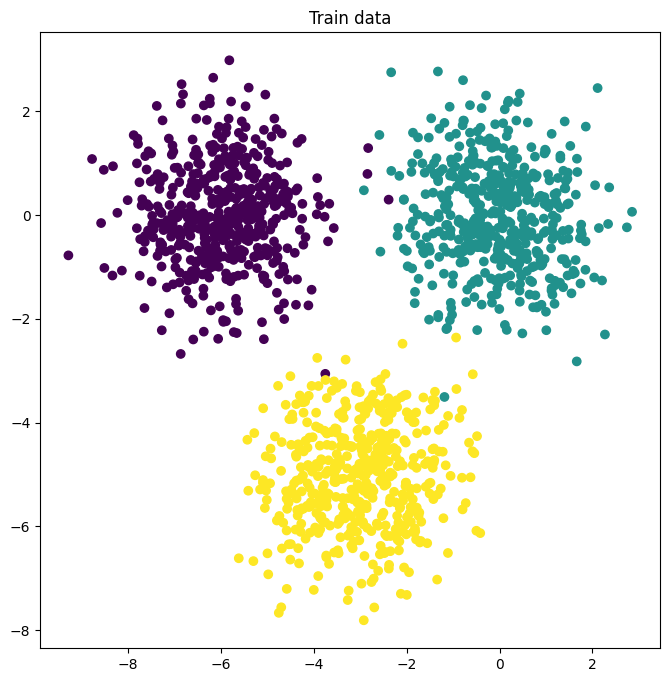

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.title('Train data')

Visualize the test data.

Text(0.5, 1.0, 'Test data')

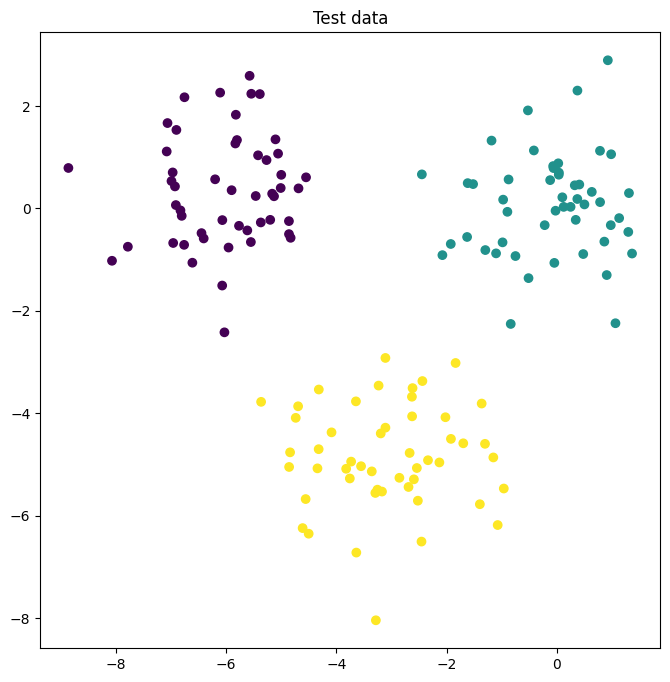

In [7]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.title('Test data')

**Sanity check:** You should have a similar graph like our training data, but now with fewer points. The colors should appear in the same area, too.

Convert the `np.ndarray` arrays to `torch.Tensor`. We use `torch.Tensor` in PyTorch.

Convert the variable `X_train` to the datatype `torch.Tensor` and assign the return value to variable `X_train`.

In [8]:
# Write your code here
X_train = torch.Tensor(X_train)

Convert the variable `y_train` to the datatype `torch.Tensor` and assign the return value to variable `y_train`.

In [9]:
# Write your code here
y_train = torch.Tensor(y_train)

Convert the variable `X_test` to the datatype `torch.Tensor` and assign the return value to variable `X_test`.

In [10]:
# Write your code here
X_test = torch.Tensor(X_test)

Convert the variable `y_test` to the datatype `torch.Tensor` and assign the return value to variable `y_test`.

In [11]:
# Write your code here
y_test = torch.Tensor(y_test)

This is the data which we will feed into our neural network model.

# Neural Network

We will follow the pseudocode below:


1. Set up the size of our network.
2. Initialize weights variables.

start loop
3. Do forward propagation.
4. Get the predictions.
5. Calculate for the loss.
6. Do backward propagation to update/optimize the weight variables.

end loop

Open `neural_network.py` file. Some of the functions in the `NeuralNetwork` class are not yet implemented. We will implement the missing parts of this class.

Import the `NeuralNetwork` class.

In [12]:
from neural_network import NeuralNetwork

## Step 1. Setting up the size of the network

Instantiate a `NeuralNetwork` object. Set the following parameters:
- `list_hidden` = (5, 10)
- `activation` = `sigmoid`

Here, we are creating a Neural Network with two hidden layers, where there are 5 units in the first layer and 10 units in the second layer.

Set the other parameters according to the synthetic dataset that we created earlier.

In [13]:
from neural_network import NeuralNetwork

list_hidden = (5, 10)
activation = "sigmoid"
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))

network = NeuralNetwork(input_size, num_classes, list_hidden, activation)

Open `neural_network.py` file and complete the `create_network()` function in the `NeuralNetwork` class. This function creates the layers of the neural network.

Implement the `create_network()` function  in the `NeuralNetwork` class. Inline comments should help you in completing the contents of the function.

Create the layers of the neural network by calling the function `create_network()`.

In [14]:
network.create_network()


List Hidden: (5, 10)


Display the structure of the neural network.

In [15]:
print(network)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)


<span style="color:red;">**Question 6-2:** Give the values of the `in_features` and `out_features` of the first `nn.Linear` module (Index 0).</span>

<span style="color:red;">**Question 6-3:** Give the values of the `in_features` and `out_features` of the last `nn.Linear` module (Index 4).</span>

<span style="color:red;">**Question 6-4:** Give the total number of parameters of the model.</span>

## Step 2. Initializing the model weights

Open `neural_network.py` file and complete the `init_weights()` function in the `NeuralNetwork` class. This function initializes the weight of the network. Weights of a `nn.Linear` layer should be initialized from a normal distribution with mean `0` and standard deviation `0.1`. Bias terms of a `nn.Linear` layer should be initialized with a constant value of `0`.

Implement the `init_weights()` function  in the `NeuralNetwork` class. Inline comments should help you in completing the contents of the function.

Initialize the weights of the neural network by calling the function `init_weights()`.

In [16]:
# Write your code here
network.init_weights()

Display the weight of the 1st `nn.Linear` layer in the network.

In [17]:
print(network.layers[0].weight)

Parameter containing:
tensor([[ 0.0392, -0.0224],
        [-0.0320, -0.1205],
        [ 0.1044, -0.0633],
        [ 0.0573,  0.0541],
        [-0.0392, -0.1043]], requires_grad=True)


**Sanity check:** The output of the previous cell should look like:

```
Parameter containing:
tensor([[ x.xxxx, x.xxxx],
        ...
        [ x.xxxx, x.xxxx]], requires_grad=True)```
        
where `x.xxxx` is some float.

<span style="color:red;">**Question 6-5:** Give the first value in the first row of the weights of the 1st `nn.Linear` layer in the network. Limit to four decimal places.</span>

Display the bias term of the 1st `nn.Linear` layer in the network.

In [18]:
print(network.layers[0].bias)

Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)


**Sanity check:** The output of the previous cell should be:

```
Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)```

Display the weight of the 2nd `nn.Linear` layer in the network.

In [19]:
# Write your code here
print(network.layers[2].weight)


Parameter containing:
tensor([[ 0.0030, -0.0050,  0.1065,  0.0886, -0.0811],
        [ 0.0674, -0.1123, -0.0092,  0.0140,  0.1119],
        [ 0.0315,  0.1753, -0.0740, -0.1242, -0.0175],
        [ 0.0699, -0.1294, -0.0024, -0.0235, -0.0709],
        [-0.0866, -0.0266,  0.0167,  0.0791, -0.0932],
        [-0.0858, -0.0965, -0.0099, -0.0299, -0.0065],
        [-0.1572, -0.1321,  0.0045,  0.1585, -0.0236],
        [ 0.0944,  0.0546, -0.1358,  0.1145, -0.0965],
        [-0.0259, -0.0042,  0.0189,  0.2143, -0.0278],
        [ 0.0551,  0.0015, -0.0918, -0.1234,  0.0254]], requires_grad=True)


<span style="color:red;">**Question 6-6:** Give the last value in the last row of the weights of the 2nd `nn.Linear` layer in the network. Limit to four decimal places.</span>

Display the bias term of the 2nd `nn.Linear` layer in the network.

In [20]:
# Write your code here
print(network.layers[2].bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


Display the weight of the 3rd `nn.Linear` layer in the network.

In [21]:
# Write your code here
print(network.layers[4].weight)

Parameter containing:
tensor([[ 0.0334,  0.0176,  0.0486,  0.0277,  0.0599, -0.0302, -0.0745, -0.1091,
         -0.1047, -0.1577],
        [ 0.0427,  0.0679,  0.0918,  0.0481,  0.0506,  0.1519, -0.0490,  0.0923,
          0.1998,  0.1483],
        [ 0.0195, -0.1137, -0.0924,  0.1874,  0.1012, -0.1448,  0.0176,  0.0606,
          0.0311, -0.1692]], requires_grad=True)


<span style="color:red;">**Question 6-7:** Give the first value in the first row of the weights of the 3rd `nn.Linear` layer in the network. Limit to four decimal places.</span>

Display the bias term of the 3rd `nn.Linear` layer in the network.

In [22]:
# Write your code here
print(network.layers[4].bias)

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


## Step 3. Forward propagation

Forward propagation computes the output of each layer in the neural network. 

Open `neural_network.py` file and complete the `forward_manual()` function in the `NeuralNetwork` class. This function performs the forward propagation of the model, implemented manually. You have to manually implement the computation of the output of each linear layer in the network.

Implement the `forward_manual()` function  in the `NeuralNetwork` class. Inline comments should help you in completing the contents of the function.

Perform forward propagation in the model by calling the function `forward_manual`. Pass the training instance in index `0`. Set `verbose=True`. Assign the return values to variables `scores` and `probabilities.`

The function should display the output of the model for in each layer.

In [23]:
# Write your code here
scores, probabilities = network.forward_manual(X_train[0].unsqueeze(0), verbose=True)


Output of layer 0:
tensor([[-0.3000,  0.1435, -0.8014, -0.3752,  0.2076]], grad_fn=<AddBackward0>) 

Output of layer 1:
tensor([[0.4256, 0.5358, 0.3097, 0.4073, 0.5517]], grad_fn=<SigmoidBackward0>) 

Output of layer 2:
tensor([[ 0.0229,  0.0331,  0.0242, -0.0891, -0.0651, -0.1070, -0.0847,  0.0208,
          0.0645, -0.0404]], grad_fn=<AddBackward0>) 

Output of layer 3:
tensor([[0.5057, 0.5083, 0.5060, 0.4778, 0.4837, 0.4733, 0.4788, 0.5052, 0.5161,
         0.4899]], grad_fn=<SigmoidBackward0>) 

Output of layer 4:
tensor([[-0.1437,  0.4208, -0.0526]], grad_fn=<AddBackward0>) 

Output of layer 5:
tensor([[0.2595, 0.4563, 0.2842]], grad_fn=<SoftmaxBackward0>) 



**Sanity check:** Let's call the pre-implemented `forward()` function of the model. This function also performs forward propagation, but using the operations defined in Pytorch modules. Thus, the output of our implementation of the `forward_manual()` function should be the same as the output of the `forward()` function below.

In [24]:
# Write your code here
scores_torch, probabilities_torch = network.forward(X_train[0].unsqueeze(0), verbose=True)


Output of layer 0
tensor([[-0.3000,  0.1435, -0.8014, -0.3752,  0.2076]],
       grad_fn=<AddmmBackward0>) 

Output of layer 1
tensor([[0.4256, 0.5358, 0.3097, 0.4073, 0.5517]], grad_fn=<SigmoidBackward0>) 

Output of layer 2
tensor([[ 0.0229,  0.0331,  0.0242, -0.0891, -0.0651, -0.1070, -0.0847,  0.0208,
          0.0645, -0.0404]], grad_fn=<AddmmBackward0>) 

Output of layer 3
tensor([[0.5057, 0.5083, 0.5060, 0.4778, 0.4837, 0.4733, 0.4788, 0.5052, 0.5161,
         0.4899]], grad_fn=<SigmoidBackward0>) 

Output of layer 4
tensor([[-0.1437,  0.4208, -0.0526]], grad_fn=<AddmmBackward0>) 

Output of layer 5
tensor([[0.2595, 0.4563, 0.2842]], grad_fn=<SoftmaxBackward0>) 



<span style="color:red;">**Question 6-8:** What is the sum of the output of the last layer of the network? Limit to four decimal places.</span>

<span style="color:red;">**Question 6-9:** Why did we get the sum?</span>

## Step 4. Getting the predictions

Since this is a multinomial classification problem, the predicted class corresponds to the class with the highest probability.

Open `neural_network.py` file and complete the `predict()` function in the `NeuralNetwork` class. This function returns the index of the class with the highest probability.

Implement the `predict()` function  in the `NeuralNetwork` class. Inline comments should help you in completing the contents of the function.

Get 10 random training instances in the dataset.

In [25]:
np.random.seed(10)
random_indices = np.random.randint(X_train.shape[0], 
                                   size=10)
print('Random indices: ', random_indices)

Random indices:  [1289 1149  527 1344 1393 1147 1180  733 1032 1097]


Compute the scores and probabilities of the random training instances by calling the function `forward()`. Assign the return values to variables `scores` and `probabilities`.

In [26]:
# Write your code here
scores, probabilities = network.forward(X_train[random_indices])


Print the raw scores of random instances in the dataset.

In [27]:
# Write your code here
print("Raw scores of random instances:")
print(scores)

Raw scores of random instances:
tensor([[-0.1422,  0.4195, -0.0527],
        [-0.1423,  0.4196, -0.0529],
        [-0.1434,  0.4207, -0.0495],
        [-0.1420,  0.4193, -0.0534],
        [-0.1417,  0.4189, -0.0538],
        [-0.1422,  0.4194, -0.0539],
        [-0.1420,  0.4193, -0.0535],
        [-0.1432,  0.4207, -0.0491],
        [-0.1418,  0.4190, -0.0543],
        [-0.1423,  0.4195, -0.0527]], grad_fn=<AddmmBackward0>)


Print the probabilities of random instances in the dataset.

In [28]:
# Write your code here
print("\nProbabilities of random instances:")
print(probabilities)


Probabilities of random instances:
tensor([[0.2599, 0.4558, 0.2843],
        [0.2599, 0.4559, 0.2842],
        [0.2593, 0.4558, 0.2848],
        [0.2600, 0.4558, 0.2841],
        [0.2602, 0.4558, 0.2841],
        [0.2600, 0.4559, 0.2840],
        [0.2600, 0.4558, 0.2841],
        [0.2593, 0.4558, 0.2849],
        [0.2602, 0.4559, 0.2840],
        [0.2599, 0.4558, 0.2843]], grad_fn=<SoftmaxBackward0>)


Get the predicted class by calling the function `predict()`. Store the predicted labels in the variable `predictions`.

In [29]:
# Write your code here
predictions = network.predict(probabilities)


In [30]:
print("Predicted class labels:")
print(predictions)

Predicted class labels:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


**Sanity Check:** All selected training examples are currently being classified under one class.

<span style="color:red;">**Question 6-10:** Obviously, the predicted class received the highest probability among the other classes. Why are all selected training examples being classified under one class?</span>

## Step 5. Calculating the loss

Since this is a multinomial classification problem, we need to use cross entropy loss.

In PyTorch, we can use `nn.CrossEntropyLoss()` to calculate the cross entropy loss between the raw score output of the model and the target class. You may read the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

Instantiate a `nn.CrossEntropy()` object. Do not change any default values set as parameter. Assign it to the variable `criterion`.

In [31]:
# Write your code here
criterion = nn.CrossEntropyLoss()

Get the target classes of the random training examples from the previous step. Convert the `torch.Tensor` to `torch.long`. This is because `nn.CrossEntropyLoss()` expects the target classes to be represented as a `long` and not `float`. Assign the return value to variable `target_classes`.

In [32]:
# Write your code here
target_classes = torch.tensor(y_train[random_indices], dtype=torch.long)

C:\Users\kobeq\AppData\Local\Temp\ipykernel_1724\3436215614.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_classes = torch.tensor(y_train[random_indices], dtype=torch.long)


Compute the loss and assign the return value to variable `loss`.

To note, the loss function accepts the score output of the model, not the probabilities. Read the documentation to understand values to pass for the `input` and the `target` parameters.

In [33]:
# Write your code here
loss = criterion(scores, target_classes)

Print the loss.

In [34]:
print('Loss: {:.4f}'.format(loss.item()))

Loss: 1.1638


<span style="color:red;">**Question 6-11:** What is the loss in this scenario? Limit to 4 decimal places.</span>

## Step 6: Backward propagation for optimizing weights

The next step would be to perform backward propagation to update the weights of the model. This will make the model better in classifying the input data. In PyTorch, we can call `backward()` function of the loss module to perform backward propagation. We also need to instantiate an optimizer to update the weights.

Read this [documentation](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step) to learn the general pseudocode for updating weights in PyTorch.

We will use Adam as our optimizer.

Instantiate an `optim.Adam` object. Set the following parameters:
- `params` = Set this to the parameters of your network
- `lr` = `0.001`

In [35]:
# Write your code here
optimizer = optim.Adam(network.parameters(), lr=0.001)

Empty the gradients of the network.

In [36]:
# Write your code here
optimizer.zero_grad()

Compute the gradients through backward propagation.

In [37]:
# Write your code here
loss.backward()

Update the weights.

In [38]:
# Write your code here
optimizer.step()

Display the weight of the 1st `nn.Linear` layer in the network after updating.

In [39]:
# Write your code here
print(network.layers[0].weight)

Parameter containing:
tensor([[ 0.0402, -0.0214],
        [-0.0310, -0.1195],
        [ 0.1034, -0.0643],
        [ 0.0563,  0.0531],
        [-0.0382, -0.1033]], requires_grad=True)


**Sanity check:** The output of the previous cell should be different from the initial set of weights, which is:

```
Parameter containing:
tensor([[ x.xxxx, x.xxxx],
        ...
        [ x.xxxx, x.xxxx]], requires_grad=True)```
        
where `x.xxxx` is some float.

<span style="color:red;">**Question 6-12:** What is the leftmost value in the weight tensor of the 1st `nn.Linear` layer in the network after updating? Limit to 4 decimal places.</span>

## Putting all steps together

We will train the model using mini-batch gradient descent. 

Use the `data_loader.py` file that we implemented in the previous notebook. Import the `DataLoader` class.

In [40]:
from data_loader import DataLoader

Instantiate an `DataLoader` object. Pass the `X` and `y` of the train set and `32` as our `batch_size`. Assign it to the variable `data_loader`.

In [41]:
# Write your code here
data_loader = DataLoader(X_train, y_train, batch_size=32)

Train your network. Complete the code below.

In [42]:
e = 0
max_epochs = 400
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # TODO: Get the batch for this epoch.
    X_batches, y_batches = data_loader.get_batch(mode='train')  

    for X_batch, y_batch in zip(X_batches, y_batches):
        X_batch = X_batch.clone().detach().float()
        y_batch = y_batch.clone().detach().long()
        
        # TODO: Empty the gradients of the network.
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        scores, probabilities = network.forward(X_batch)
        
        # TODO: Compute the loss
        loss = criterion(scores, y_batch)
        
        # TODO: Backward propagation
        loss.backward()
        
        # TODO: Update parameters
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 1.871857
Epoch: 2 	Loss: 1.846745
Epoch: 3 	Loss: 1.839984
Epoch: 4 	Loss: 1.833624
Epoch: 5 	Loss: 1.824633
Epoch: 6 	Loss: 1.812243
Epoch: 7 	Loss: 1.792462
Epoch: 8 	Loss: 1.766554
Epoch: 9 	Loss: 1.730851
Epoch: 10 	Loss: 1.686186
Epoch: 11 	Loss: 1.629144
Epoch: 12 	Loss: 1.559562
Epoch: 13 	Loss: 1.477712
Epoch: 14 	Loss: 1.385541
Epoch: 15 	Loss: 1.283884
Epoch: 16 	Loss: 1.177541
Epoch: 17 	Loss: 1.071287
Epoch: 18 	Loss: 0.968326
Epoch: 19 	Loss: 0.870047
Epoch: 20 	Loss: 0.779066
Epoch: 21 	Loss: 0.696493
Epoch: 22 	Loss: 0.621949
Epoch: 23 	Loss: 0.556199
Epoch: 24 	Loss: 0.497954
Epoch: 25 	Loss: 0.446877
Epoch: 26 	Loss: 0.402166
Epoch: 27 	Loss: 0.362779
Epoch: 28 	Loss: 0.328420
Epoch: 29 	Loss: 0.298610
Epoch: 30 	Loss: 0.272334
Epoch: 31 	Loss: 0.249419
Epoch: 32 	Loss: 0.229258
Epoch: 33 	Loss: 0.210928
Epoch: 34 	Loss: 0.195225
Epoch: 35 	Loss: 0.180726
Epoch: 36 	Loss: 0.168088
Epoch: 37 	Loss: 0.156785
Epoch: 38 	Loss: 0.146614
Epoch: 39 	Loss: 0.13

<span style="color:red;">**Question 6-13:** How many epochs did the model train before convergence?</span>

<span style="color:red;">**Question 6-14:** What is the average loss at the last epoch? Limit to four decimal places.</span>

## Try our trained network on the test data

Set the network in test `eval` mode first, to avoid updating the weights.

In [43]:
network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

Perform forward propagation on the test data. Assign the return values to variables `scores` and `probabilities`.

In [ ]:
# Write your code here
with torch.no_grad():
    scores, probabilities = network(X_test)
    


Now, let's get the prediction results on the test data to see if our model can handle unseen instances. Store the predicted labels in the variable `predictions`.

In [47]:
# Write your code here
predictions = torch.argmax(probabilities, dim=1)  # Get the index of max probability


In [48]:
print(predictions)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])


Compare the ground truth labels with the predicted labels. Store the total number of correct predictions in the variable `num_correct`.

In [ ]:
# Write your code here
num_correct = (predictions == y_test).sum().item()


In [51]:
print(num_correct)

150


Compute for the accuracy. Store the accuracy in the variable `accuracy`.

In [52]:
# Write your code here
accuracy = num_correct / len(y_test)  # Compute accuracy


In [53]:
print('{:.4f}'.format(accuracy))

1.0000


<span style="color:red;">**Question 6-15:** What is the accuracy of the network when evaluated on the test set? Express your answer in a floating point number from 0 to 1. Limit to 4 decimal places.</span>

Let's visualize the loss for each training epoch.

Text(0.5, 1.0, 'Loss for each training epoch')

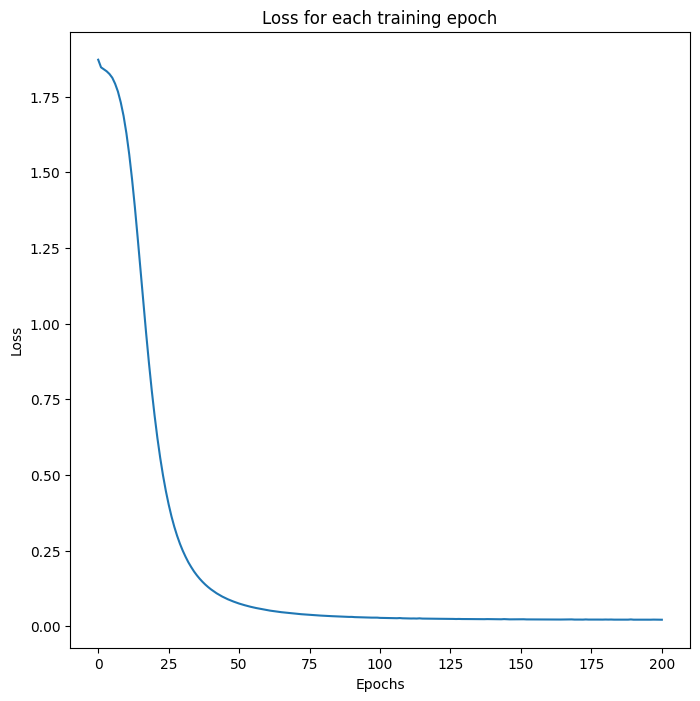

In [54]:
x_values = [i for i in range(len(losses))]
y_values = losses

plt.plot(x_values, y_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for each training epoch')

<span style="color:green;">**Question:** Around what epoch did our training converge, i.e., when there are minimal changes in the value of the loss?</span>

# Iris Dataset
We will use the Iris dataset as our dataset. Each instance represents an Iris flower using 4 distinct features:
- `sepal_length` - length of the sepal in centimeters
- `sepal_width` - width of the sepal in centimeters
- `petal_length` - length of the petal in centimeters
- `petal_width` - width of the petal in centimeters

Iris flowers can be 3 divided into different classes, which are:
- `Iris-setosa` - class `0`
- `Iris-versicolor` - class `1`
- `Iris-virginica` - class `2`

Let's load `Iris.csv`.

In [55]:
classes = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
}

with open('Iris.csv', 'r') as csv_file:
    raw_data = csv.reader(csv_file)
    X_iris = np.empty((0, 4), float)
    y_iris = np.empty((0, 1), int)
    for row in raw_data:
        X_iris = np.vstack([X_iris, np.array([float(row[0]),     # column for sepal_length
                                              float(row[1]),     # column for sepal_width
                                              float(row[2]),     # column for petal_length
                                              float(row[3])])])  # column for petal_width
        
        y_iris = np.append(y_iris, np.array([classes[row[4]]]))  # column for class

# This transforms the vector of length N into a matrix with shape (N, 1)
y_house = np.expand_dims(y_iris, 1) 

print('Training data shape:', X_iris.shape)
print('Ground truth values shape:', y_iris.shape)

Training data shape: (150, 4)
Ground truth values shape: (150,)


Let's get the number of instances per class.

In [56]:
X_iris_0 = X_iris[y_iris == 0]
X_iris_1 = X_iris[y_iris == 1]
X_iris_2 = X_iris[y_iris == 2]

print('Number of class 0:', len(X_iris_0))
print('Number of class 1:', len(X_iris_1))
print('Number of class 2:', len(X_iris_2))

Number of class 0: 50
Number of class 1: 50
Number of class 2: 50


There are 50 instances for each class.

Let's divide the dataset into train and test set. The test set will contain 10 instances for each class.

In [57]:
np.random.seed(1)

# Select 10 `class 0` instances
selected_0 = np.random.choice(np.arange(len(X_iris_0)),
                              size=10,
                              replace=False)

# Select 10 `class 1` instances
selected_1 = np.random.choice(np.arange(len(X_iris_1)),
                              size=10,
                              replace=False)

# Select 10 `class 2` instances
selected_2 = np.random.choice(np.arange(len(X_iris_2)),
                              size=10,
                              replace=False)

# Form the test set
X_test = np.concatenate((X_iris_0[selected_0],
                         X_iris_1[selected_1],
                         X_iris_2[selected_2]))
y_test = np.concatenate((np.array([0 for _ in range(10)]),
                         np.array([1 for _ in range(10)]),
                         np.array([2 for _ in range(10)])))

print(X_test.shape)
print(y_test.shape)

(30, 4)
(30,)


The remaining 120 instances will be a part of the train set, where each class has 40 instances.

In [58]:
X_train = np.concatenate((np.delete(X_iris_0, selected_0, 0),
                          np.delete(X_iris_1, selected_1, 0),
                          np.delete(X_iris_2, selected_2, 0)))
y_train = np.concatenate((np.array([0 for _ in range(40)]),
                          np.array([1 for _ in range(40)]),
                          np.array([2 for _ in range(40)])))

print(X_train.shape)
print(y_train.shape)

(120, 4)
(120,)


Convert the `np.ndarray` arrays to `torch.Tensor`. We use `torch.Tensor` in PyTorch.

Convert the variable `X_train` to the datatype `torch.Tensor` and assign the return value to variable `X_train`.

In [78]:
# Write your code here
X_train = torch.tensor(X_train)

C:\Users\kobeq\AppData\Local\Temp\ipykernel_1724\2902836516.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train)


Convert the variable `y_train` to the datatype `torch.Tensor` and assign the return value to variable `y_train`.

In [100]:
# Write your code here
y_train = torch.tensor(y_train, dtype=torch.long)

C:\Users\kobeq\AppData\Local\Temp\ipykernel_1724\4075887742.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)


Convert the variable `X_test` to the datatype `torch.Tensor` and assign the return value to variable `X_test`.

In [101]:
# Write your code here
X_test = torch.Tensor(X_test)

Convert the variable `y_test` to the datatype `torch.Tensor` and assign the return value to variable `y_test`.

In [103]:
# Write your code here
y_test = torch.tensor(y_test, dtype=torch.long)

C:\Users\kobeq\AppData\Local\Temp\ipykernel_1724\3571691089.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


## Setting up the training pipeline

Set-up the following:
- Network
- Optimizer
- Loss function
- Data loader

Instantiate a `NeuralNetwork` object. Set the following parameters:
- `list_hidden` = (5, 10)
- `activation` = `sigmoid`

Here, we are creating a Neural Network with two hidden layers, where there are 5 units in the first layer and 10 units in the second layer.

Set the other parameters according to the Iris dataset.

In [95]:
# Write your code here
list_hidden = (5, 10)
activation = "sigmoid"
input_size = X_train.shape[1]
num_classes = len(torch.unique(y_train))
network = NeuralNetwork(input_size, num_classes, list_hidden, activation)

Create the network and initialize the weights.

In [104]:
# Write your code here
network.create_network()
network.init_weights()

List Hidden: (5, 10)


Display the structure of the neural network.

In [105]:
# Write your code here
print(network)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)


<span style="color:red;">**Question 6-16:** Give the values of the `in_features` and `out_features of the first `nn.Linear` module (Index 0).</span>

<span style="color:red;">**Question 6-17:** Give the values of the `in_features` and `out_features` of the last `nn.Linear` module (Index 4).</span>

We will use Adam as our optimizer.

Instantiate an `optim.Adam` object. Set the following parameters:
- `params` = Set this to the parameters of your network
- `lr` = `0.001`

In [106]:
# Write your code here
optimizer = optim.Adam(network.parameters(), lr=0.001)

Instantiate a `nn.CrossEntropy()` object. Do not change any default values set as parameter. Assign it to the variable `criterion`.

In [107]:
# Write your code here
criterion = nn.CrossEntropyLoss()

We will train the model using mini-batch gradient descent. 

Instantiate a `DataLoader` object. Pass the `X` and `y` of the train set and `32` as our `batch_size`. Assign it to the variable `data_loader`.

In [108]:
# Write your code here
data_loader = DataLoader(X_train, y_train, batch_size=32)

## Training the network

Train your network. Complete the code below.

In [113]:
e = 0
max_epochs = 300
is_converged = False
previous_loss = 0
losses = []

# For each epoch
while e < max_epochs and is_converged is not True:
    
    current_epoch_loss = 0
    
    # TODO: Get the batch for this epoch.
    X_batches, y_batches = data_loader.get_batch(mode='train')  

    for X_batch, y_batch in zip(X_batches, y_batches):
        X_batch = X_batch.clone().detach().float()
        y_batch = y_batch.clone().detach().long()
        
        # TODO: Empty the gradients of the network.
        optimizer.zero_grad()
        
        # TODO: Forward propagation
        scores, probabilities = network.forward(X_batch)
        
        # TODO: Compute the loss
        loss = criterion(scores, y_batch)
        
        # TODO: Backward propagation
        loss.backward()
        
        # TODO: Update parameters
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.00005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1

Epoch: 1 	Loss: 0.055520
Epoch: 2 	Loss: 0.055270
Epoch: 3 	Loss: 0.055012
Epoch: 4 	Loss: 0.054319
Epoch: 5 	Loss: 0.054320
Epoch: 6 	Loss: 0.053932
Epoch: 7 	Loss: 0.053743
Epoch: 8 	Loss: 0.052922
Epoch: 9 	Loss: 0.052801
Epoch: 10 	Loss: 0.053476
Epoch: 11 	Loss: 0.052126
Epoch: 12 	Loss: 0.053127
Epoch: 13 	Loss: 0.053094
Epoch: 14 	Loss: 0.052865
Epoch: 15 	Loss: 0.051856
Epoch: 16 	Loss: 0.052017
Epoch: 17 	Loss: 0.051525
Epoch: 18 	Loss: 0.051630
Epoch: 19 	Loss: 0.050747
Epoch: 20 	Loss: 0.050672
Epoch: 21 	Loss: 0.051073
Epoch: 22 	Loss: 0.050270
Epoch: 23 	Loss: 0.050339
Epoch: 24 	Loss: 0.049822
Epoch: 25 	Loss: 0.050296
Epoch: 26 	Loss: 0.049769
Epoch: 27 	Loss: 0.049230
Epoch: 28 	Loss: 0.049213
Epoch: 29 	Loss: 0.048132
Epoch: 30 	Loss: 0.048369
Epoch: 31 	Loss: 0.048257
Epoch: 32 	Loss: 0.048794
Epoch: 33 	Loss: 0.048211
Epoch: 34 	Loss: 0.048106
Epoch: 35 	Loss: 0.047582
Epoch: 36 	Loss: 0.047557
Epoch: 37 	Loss: 0.047068
Epoch: 38 	Loss: 0.047047
Epoch: 39 	Loss: 0.04

## Try our trained network on the test data

Set the network in test `eval` mode first, to avoid updating the weights.

In [114]:
network.eval()

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

Perform forward propagation on the test data. Assign the return values to variables `scores` and `probabilities`.

In [116]:
# Write your code here
scores, probabilities = network.forward(X_test)

Now, let's get the prediction results on the test data to see if our model can handle unseen instances. Store the predicted labels in the variable `predictions`.

In [117]:
# Write your code here
predictions = torch.argmax(probabilities, dim=1)

In [118]:
print(predictions)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])


Compare the ground truth labels with the predicted labels. Store the total number of correct predictions in the variable `num_correct`.

In [119]:
# Write your code here
num_correct = torch.sum(predictions == y_test.long()).item()

In [120]:
print(num_correct)

29


Compute for the accuracy. Store the accuracy in the variable `accuracy`.

In [121]:
# Write your code here
accuracy = num_correct / len(y_test)

In [122]:
print('{:.4f}'.format(accuracy))

0.9667


<span style="color:red;">**Question 6-18:** What is the accuracy of the network when evaluated on the test set? Express your answer in a floating point number from 0 to 1. Limit to 4 decimal places.</span>

### <center>fin</center>


<!-- DO NOT MODIFY OR DELETE THIS -->
<sup>made/compiled by daniel stanley tan & courtney anne ngo 🐰 & thomas james tiam-lee</sup> <br>
<sup>for comments, corrections, suggestions, please email:</sup><sup> danieltan07@gmail.com & courtneyngo@gmail.com & thomasjamestiamlee@gmail.com</sup><br>
<sup>please cc your instructor, too</sup>
<!-- DO NOT MODIFY OR DELETE THIS -->